# Generative Adverserial Network

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from keras.layers import Reshape, UpSampling2D, MaxPooling2D, Activation
from keras.datasets import mnist, fashion_mnist
from keras.optimizers import SGD
from keras.utils import to_categorical
from PIL import Image

Using TensorFlow backend.


## Generator Model

In [2]:
def generator_model():
    model = Sequential([
        Dense(1024, input_dim=100, activation='tanh'),
        Dense(128*7*7),
        BatchNormalization(),
        Activation('tanh'),
        Reshape((7, 7, 128)),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (5, 5), padding='same', activation='tanh'),
        UpSampling2D(size=(2, 2)),
        Conv2D(1, (5, 5), padding='same', activation='tanh')
    ])
    return model

generator_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_1 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
__________

## Discriminator Model

In [3]:
def discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), input_shape=(28, 28, 1), padding='same', activation='tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (5, 5),activation='tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(1024, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              3277824   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total para

In [4]:
z_size = 100
g_model = generator_model()
d_model = discriminator_model()

### Generator + Discriminator

In [5]:
def combine_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

## Training
untuk melakukan training diperlukan BATCH_SIZE yang merupakan banyaknya gambar yang di train tiap epochs nya. Tiap piksel gambar akan dikonversikan menjadi nilai antara [-1,1). Hasil training akan disimpan pada file discriminator dan generator. Jumlah epochs pada contoh kali ini adalah 100 epochs

In [6]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [7]:
def train_gan(X_train, Y_train, batch_size, epochs, g, d, save_every=500, print_every=100):
    
    # ukuran vektor z
    z_size = g.layers[0].input_shape[1]
    
    # gabungkan Discriminator dan Generator
    d.trainable = False                                 # set Discriminator tidak bisa dilatih sebelum digabung
    d_on_g = combine_model(g, d)    
    dg_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    d_on_g.compile(loss='binary_crossentropy', optimizer=dg_optim)
    
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    
    # set Discriminator agar bisa dilatih kembali
    d.trainable = True
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    
    # mulai pelatihan
    for epoch in range(epochs):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/batch_size))
        
        for index in range(int(X_train.shape[0]/batch_size)):
            
            # bangkitkan matrix z secara acak
            noise = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # bangkitkan data citra palsu dari matrix z
            generated_images = g.predict(noise, verbose=0)
            
            # ambil data citra asli
            image_batch = X_train[index*batch_size:(index+1)*batch_size]
            
            if index % save_every == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save("images/train_ep"+
                    str(epoch)+"_"+str(index)+".png")
                
            # gabungkan data untuk pelatihan Discriminator
            X = np.concatenate((image_batch, generated_images))
            y = [1] * batch_size + [0] * batch_size
            
            # latih Discriminator
            d_loss = d.train_on_batch(X, y)           
            if index % print_every == 0: 
                print("batch %d d_loss : %f" % (index, d_loss))
            
            # bangkitkan matrix z secara acak untuk pelatihan Generator
            noise = np.random.uniform(-1, 1, (batch_size, z_size))
            
            # set Discriminator tidak bisa dilatih sebelum digabung
            d.trainable = False            
            
            # latih Generator
            g_loss = d_on_g.train_on_batch(noise, [1] * batch_size)
            if index % print_every == 0: 
                print("batch %d g_loss : %f" % (index, g_loss))
            
            # set Discriminator agar bisa dilatih kembali
            d.trainable = True       
            
        # simpan model di akhir epoch
        g.save('./model/generator.h5', True)
        d.save('./model/discriminator.h5', True)
        
    return g, d

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]
X_test = X_test[:, :, :, None]

In [9]:
batch = 500
epochs = 200
g_model, d_model = train_gan(X_train,y_train, batch, epochs, g_model, d_model)

Epoch is 0
Number of batches 120
batch 0 d_loss : 0.704546
batch 0 g_loss : 0.688731
batch 100 d_loss : 0.332292
batch 100 g_loss : 1.439136
Epoch is 1
Number of batches 120
batch 0 d_loss : 0.258429
batch 0 g_loss : 1.848421
batch 100 d_loss : 0.496119
batch 100 g_loss : 0.939854
Epoch is 2
Number of batches 120
batch 0 d_loss : 0.490544
batch 0 g_loss : 0.952163
batch 100 d_loss : 0.383096
batch 100 g_loss : 1.189996
Epoch is 3
Number of batches 120
batch 0 d_loss : 0.383030
batch 0 g_loss : 1.252200
batch 100 d_loss : 0.409295
batch 100 g_loss : 1.219603
Epoch is 4
Number of batches 120
batch 0 d_loss : 0.419226
batch 0 g_loss : 1.286556
batch 100 d_loss : 0.452994
batch 100 g_loss : 1.166301
Epoch is 5
Number of batches 120
batch 0 d_loss : 0.473870
batch 0 g_loss : 1.168824
batch 100 d_loss : 0.470513
batch 100 g_loss : 1.135352
Epoch is 6
Number of batches 120
batch 0 d_loss : 0.475288
batch 0 g_loss : 1.176823
batch 100 d_loss : 0.464551
batch 100 g_loss : 1.162706
Epoch is 7
Nu

Epoch is 58
Number of batches 120
batch 0 d_loss : 0.337058
batch 0 g_loss : 1.345039
batch 100 d_loss : 0.323948
batch 100 g_loss : 1.478474
Epoch is 59
Number of batches 120
batch 0 d_loss : 0.377635
batch 0 g_loss : 1.229703
batch 100 d_loss : 0.344019
batch 100 g_loss : 1.493981
Epoch is 60
Number of batches 120
batch 0 d_loss : 0.350471
batch 0 g_loss : 1.791148
batch 100 d_loss : 0.367255
batch 100 g_loss : 1.611049
Epoch is 61
Number of batches 120
batch 0 d_loss : 0.346621
batch 0 g_loss : 1.535832
batch 100 d_loss : 0.372685
batch 100 g_loss : 1.722885
Epoch is 62
Number of batches 120
batch 0 d_loss : 0.343004
batch 0 g_loss : 1.662566
batch 100 d_loss : 0.341825
batch 100 g_loss : 1.669942
Epoch is 63
Number of batches 120
batch 0 d_loss : 0.360849
batch 0 g_loss : 1.241870
batch 100 d_loss : 0.339515
batch 100 g_loss : 1.537014
Epoch is 64
Number of batches 120
batch 0 d_loss : 0.367501
batch 0 g_loss : 1.153713
batch 100 d_loss : 0.362471
batch 100 g_loss : 1.566876
Epoch 

batch 100 d_loss : 0.324237
batch 100 g_loss : 1.834541
Epoch is 116
Number of batches 120
batch 0 d_loss : 0.369872
batch 0 g_loss : 1.819642
batch 100 d_loss : 0.335988
batch 100 g_loss : 1.576137
Epoch is 117
Number of batches 120
batch 0 d_loss : 0.409607
batch 0 g_loss : 1.474880
batch 100 d_loss : 0.319966
batch 100 g_loss : 1.907426
Epoch is 118
Number of batches 120
batch 0 d_loss : 0.396701
batch 0 g_loss : 2.302480
batch 100 d_loss : 0.327709
batch 100 g_loss : 1.631750
Epoch is 119
Number of batches 120
batch 0 d_loss : 0.433548
batch 0 g_loss : 1.227763
batch 100 d_loss : 0.318773
batch 100 g_loss : 1.660426
Epoch is 120
Number of batches 120
batch 0 d_loss : 0.424318
batch 0 g_loss : 1.132113
batch 100 d_loss : 0.321345
batch 100 g_loss : 1.783113
Epoch is 121
Number of batches 120
batch 0 d_loss : 0.484707
batch 0 g_loss : 1.033249
batch 100 d_loss : 0.322018
batch 100 g_loss : 1.688543
Epoch is 122
Number of batches 120
batch 0 d_loss : 0.354788
batch 0 g_loss : 1.891979

Epoch is 173
Number of batches 120
batch 0 d_loss : 0.471431
batch 0 g_loss : 0.967202
batch 100 d_loss : 0.315326
batch 100 g_loss : 1.670390
Epoch is 174
Number of batches 120
batch 0 d_loss : 0.423250
batch 0 g_loss : 1.357484
batch 100 d_loss : 0.328400
batch 100 g_loss : 1.639618
Epoch is 175
Number of batches 120
batch 0 d_loss : 0.396489
batch 0 g_loss : 1.363390
batch 100 d_loss : 0.298859
batch 100 g_loss : 1.913868
Epoch is 176
Number of batches 120
batch 0 d_loss : 0.400052
batch 0 g_loss : 1.230629
batch 100 d_loss : 0.305311
batch 100 g_loss : 2.093871
Epoch is 177
Number of batches 120
batch 0 d_loss : 0.402755
batch 0 g_loss : 1.240877
batch 100 d_loss : 0.309645
batch 100 g_loss : 1.831065
Epoch is 178
Number of batches 120
batch 0 d_loss : 0.439223
batch 0 g_loss : 1.109805
batch 100 d_loss : 0.300902
batch 100 g_loss : 1.900458
Epoch is 179
Number of batches 120
batch 0 d_loss : 0.386469
batch 0 g_loss : 1.387078
batch 100 d_loss : 0.305749
batch 100 g_loss : 2.033202

## Generate gambar
pada fungsi ini gambar bisa digenerate dengan input BATCH_SIZE yang menunjukan jumlah gambar yang akan digenerate. parameter nice digunakan untuk menghasilkan gambar-gambar dengan kualitas terbaik

In [10]:
def generate_images(g, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = np.random.uniform(-1, 1, (batch_size, z_size))
    generated_images = g.predict(noise, verbose=1)
    image = combine_images(generated_images)
    filename = "generated_image.png"
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

100/100 [==============================] - 0s 120us/step


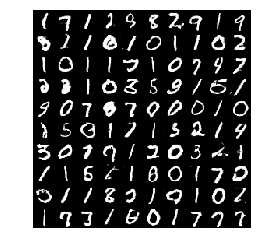

In [11]:
images = generate_images(g_model, 100)
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [12]:
def generate_best_images(g, d, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = np.random.uniform(-1, 1, (batch_size*20, z_size))

    generated_images = g.predict(noise, verbose=1)
    d_pret = d.predict(generated_images, verbose=1)

    index = np.arange(0, batch_size*20)
    index.resize((batch_size*20, 1))

    pre_with_index = list(np.append(d_pret, index, axis=1))
    pre_with_index.sort(key=lambda x: x[0], reverse=True)

    nice_images = np.zeros((batch_size,) + generated_images.shape[1:3], dtype=np.float32)
    nice_images = nice_images[:, :, :, None]

    for i in range(batch_size):
        idx = int(pre_with_index[i][1])
        nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]

    image = combine_images(nice_images)
    filename = "generated_image_best.png"
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

2000/2000 [==============================] - 0s 77us/step


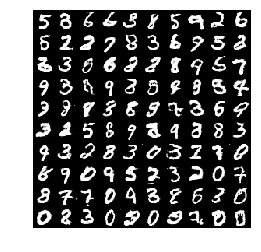

In [13]:
images = generate_best_images(g_model, d_model, 100)
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

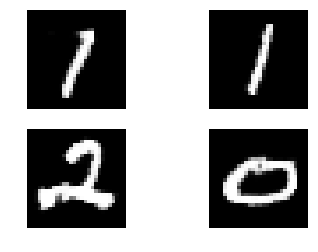

In [14]:
seed = np.random.uniform(-1, 1, (4, 100))
images = g_model.predict(seed)

for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()